In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [83]:
df = pd.read_csv('data/co_avg.csv', parse_dates=['Date'])
df.head()

,Date,CO,StationCount
0,2010-01-01,1.249956,5
1,2010-01-16,1.211964,5
2,2010-02-01,1.240417,4
3,2010-02-16,1.334615,6
4,2010-03-01,1.078095,6


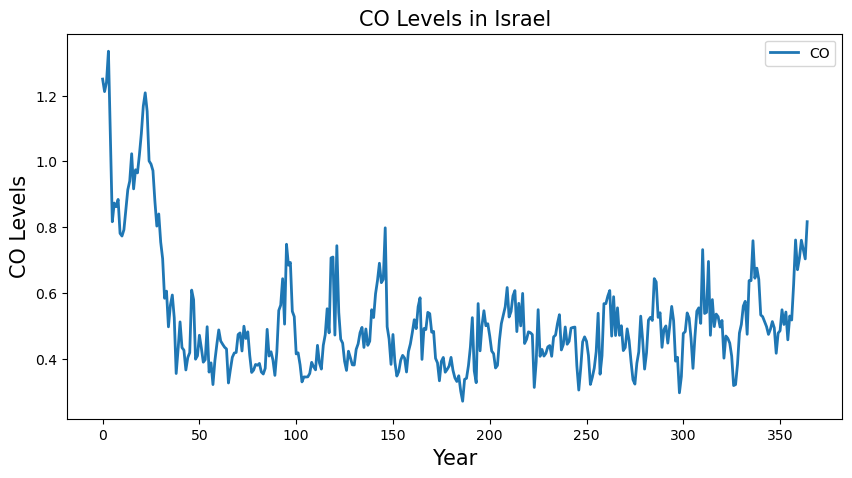

In [84]:
dfCO = df[["CO"]]
dfCO.plot(figsize=(10,5), linewidth=2, fontsize=10)
plt.title("CO Levels in Israel",fontsize=15)
plt.xlabel('Year', fontsize=15)

plt.ylabel('CO Levels', fontsize=15);

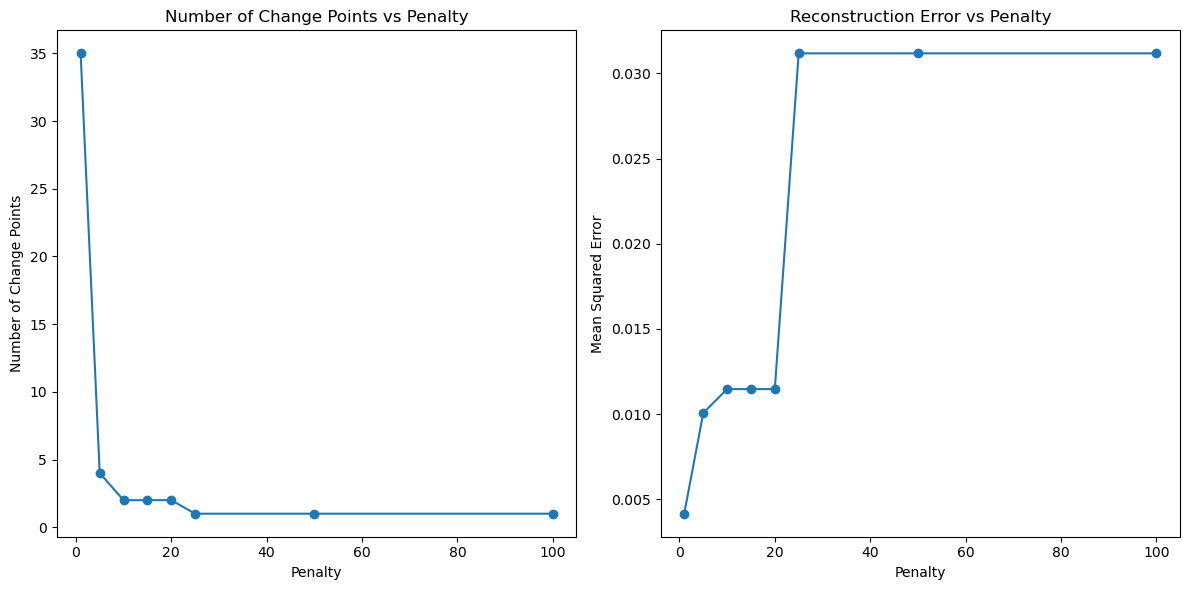

In [85]:
import ruptures as rpt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Load and prepare data
# Assuming df contains our CO data already loaded
signal = df['CO'].values

# Function to evaluate different penalty values
def evaluate_penalties(signal, penalty_range):
    results = {}
    for penalty in penalty_range:
        # Apply PELT algorithm
        algo = rpt.Pelt(model="rbf").fit(signal)
        change_pts = algo.predict(pen=penalty)
        
        # Calculate segments and their means
        segments = []
        for i in range(len(change_pts)):
            if i == 0:
                segment = signal[0:change_pts[i]]
            else:
                segment = signal[change_pts[i-1]:change_pts[i]]
            segments.append(segment)
            
        # Calculate reconstruction error
        reconstructed = np.zeros_like(signal)
        idx = 0
        for i, segment in enumerate(segments):
            segment_mean = np.mean(segment)
            segment_len = len(segment)
            reconstructed[idx:idx+segment_len] = segment_mean
            idx += segment_len
            
        mse = mean_squared_error(signal, reconstructed)
        results[penalty] = {
            'change_points': len(change_pts),
            'mse': mse,
            'indices': change_pts
        }
    
    return results

# Evaluate a range of penalties
penalty_range = [1, 5, 10, 15, 20, 25, 50, 100]
results = evaluate_penalties(signal, penalty_range)

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot([p for p in penalty_range], [results[p]['change_points'] for p in penalty_range], 'o-')
plt.xlabel('Penalty')
plt.ylabel('Number of Change Points')
plt.title('Number of Change Points vs Penalty')

plt.subplot(1, 2, 2)
plt.plot([p for p in penalty_range], [results[p]['mse'] for p in penalty_range], 'o-')
plt.xlabel('Penalty')
plt.ylabel('Mean Squared Error')
plt.title('Reconstruction Error vs Penalty')
plt.tight_layout()
plt.show()


Based on the graphs, a penalty of 10 is optimal as it identifies 2-3 significant change points while avoiding over-segmentation (seen at lower penalties) and maintains a reasonable reconstruction error before the error jumps at higher penalties. This represents the sweet spot in the tradeoff between model sensitivity and specificity.


C:\Users\sinit\AppData\Local\Temp\ipykernel_36880\3233935755.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


Detected change point indices: [30]


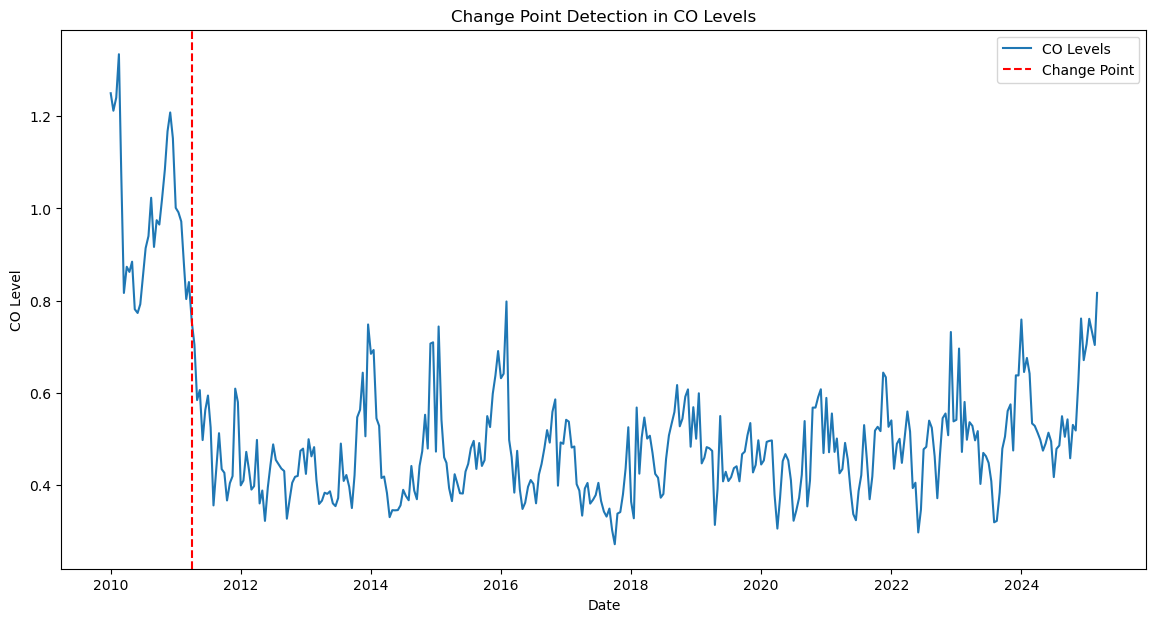

[30]

In [86]:
def detect_change_points(df, penalty: float = 10,data_type: str = 'CO'):
    """
    performs change point detection on the 'CO' column
    using the PELT algorithm with a specified penalty value, and plots the results.
    
    Args:
        df: time series dataframe.
        penalty (float): Penalty value for the PELT algorithm to control sensitivity.
        

    Returns:
        list: A list of change point indices.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import ruptures as rpt

    # Load data and set the date index
    df.set_index('Date', inplace=True)
    df = df[[data_type]]
    
    # Remove missing CO values, if any
    df.dropna(inplace=True)

    # Extract the time series as a numpy array
    signal = df[data_type].values

    # Applying the PELT algorithm with a 'rbf' model – you can experiment with other models like "l2"
    algo = rpt.Pelt(model="rbf").fit(signal)
    all_change_pts = algo.predict(pen=penalty)
    # Filter out change points that exceed data length
    change_pt_indices = [cp for cp in all_change_pts if cp < len(df)]
    
    print("Detected change point indices:", change_pt_indices)

    # Plot the CO time series with the detected change points
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, signal, label="CO Levels")
    
    # Mark each change point with a red dashed vertical line.
    # Note: The change point index returned by ruptures is the index of the segment's end.
    for cp in change_pt_indices:
        if cp < len(df):  # Ensure the index exists in the data
            plt.axvline(x=df.index[cp], color="red", linestyle="--",
                        label="Change Point" if cp == change_pt_indices[0] else "")
    
    plt.title("Change Point Detection in CO Levels")
    plt.xlabel("Date")
    plt.ylabel("CO Level")
    plt.legend()
    plt.show()

    return change_pt_indices

detect_change_points(df, penalty=15,data_type='CO')

# Change Point Detection with PELT Algorithm

## How PELT Works
* **PELT** (Pruned Exact Linear Time) algorithm finds points where statistical properties change
* Works by minimizing a cost function across possible segmentations
* Uses dynamic programming with pruning for computational efficiency
* Penalty parameter (15) controls sensitivity - higher values produce fewer change points
* RBF model used to detect changes in mean, variance, and other statistical properties

## Significant Dates Detected
* **Index 30** ≈ March 2011 (15th sample ≈ mid-March 2011) - The updated clean air regulations https://www.nevo.co.il/law_html/law00/98612.htm might have a connection to this

## Penalty Selection (15)
* Provides balanced sensitivity to detect meaningful changes
* Avoids too many false positives while capturing significant shifts
* Likely determined through experimentation with the dataset
* Represents optimal tradeoff for environmental time series analysis
